In [6]:
import requests
import pandas as pd
from datetime import datetime, timedelta, timezone

# Choose stretch: "isis", "godstow", or "wallingford"
STRETCH = "isis"  # change this to "godstow" or "wallingford" when needed

# Mapping from stretch name to API id and CSV basename
STRETCH_CONFIG = {
    "isis":       {"id": 1, "csv_basename": "isis_flag_model_data"},
    "godstow":    {"id": 2, "csv_basename": "godstow_flag_model_data"},
    "wallingford": {"id": 5, "csv_basename": "wallingford_flag_model_data"},
}

BASE_URL = "https://flags.jamesonlee.com/api/flow"
STRETCH_ID = STRETCH_CONFIG[STRETCH]["id"]
CSV_BASENAME = STRETCH_CONFIG[STRETCH]["csv_basename"]

start_date = datetime(2017, 1, 1, tzinfo=timezone.utc)  # or whatever start you want
end_date   = datetime.now(tz=timezone.utc)

all_chunks = []

current = start_date
while current < end_date:
    day_start = current
    day_end   = min(current + timedelta(days=1), end_date)

    start_ms = int(day_start.timestamp() * 1000)
    end_ms   = int(day_end.timestamp() * 1000)

    params = {"start": start_ms, "end": end_ms}
    resp = requests.get(f"{BASE_URL}/{STRETCH_ID}/", params=params, timeout=30)
    resp.raise_for_status()
    data = resp.json()

    if data:
        df_day = pd.DataFrame(data)
        df_day["timestamp"] = pd.to_datetime(df_day["time"])
        all_chunks.append(df_day)

    print(f"{day_start.date()} → {len(data)} rows")

    current = day_end

# Combine all days into one DataFrame
df = pd.concat(all_chunks, ignore_index=True).sort_values("timestamp")

# Map flags / rename columns
flag_map = {
    0: 'Grey',
    1: 'Green',
    15: 'Light Blue',
    2: 'Blue',
    3: 'Amber',
    4: 'Red',
    None: 'Grey',
}
df["flag_status"] = df["flag"].map(flag_map)
df["jameson_differential"] = df["flow"]

out = df[["timestamp", "jameson_differential", "flag_status"]]

2017-01-01 → 0 rows
2017-01-02 → 0 rows
2017-01-03 → 0 rows
2017-01-04 → 0 rows
2017-01-05 → 0 rows
2017-01-06 → 0 rows
2017-01-07 → 0 rows
2017-01-08 → 0 rows
2017-01-09 → 0 rows
2017-01-10 → 0 rows
2017-01-11 → 0 rows
2017-01-12 → 0 rows
2017-01-13 → 0 rows
2017-01-14 → 0 rows
2017-01-15 → 0 rows
2017-01-16 → 0 rows
2017-01-17 → 0 rows
2017-01-18 → 0 rows
2017-01-19 → 0 rows
2017-01-20 → 0 rows
2017-01-21 → 0 rows
2017-01-22 → 0 rows
2017-01-23 → 0 rows
2017-01-24 → 0 rows
2017-01-25 → 0 rows
2017-01-26 → 0 rows
2017-01-27 → 0 rows
2017-01-28 → 0 rows
2017-01-29 → 0 rows
2017-01-30 → 0 rows
2017-01-31 → 0 rows
2017-02-01 → 0 rows
2017-02-02 → 0 rows
2017-02-03 → 0 rows
2017-02-04 → 11 rows
2017-02-05 → 22 rows
2017-02-06 → 18 rows
2017-02-07 → 15 rows
2017-02-08 → 17 rows
2017-02-09 → 16 rows
2017-02-10 → 22 rows
2017-02-11 → 20 rows
2017-02-12 → 23 rows


KeyboardInterrupt: 

In [11]:
#!/usr/bin/env python
"""
Fetch rainfall forecast from Open-Meteo Ensemble API for a location.

Uses the same API and logic as the pipeline; only the set of stations (lat/lon)
differs by location:

  - isis:   13 stations (RAINFALL_STATION_COORDINATES)
  - godstow: 11 stations (same set minus Bicester, Grimsbury)
  - wallingford: 19 stations (13 base + 6 Wallingford-specific)

Usage (from project root):

  python get_rainfall_forecast.py --location isis
  python get_rainfall_forecast.py --location godstow --output data/forecast_rain_godstow.csv
  python get_rainfall_forecast.py --location wallingford --n-members 20
"""

from __future__ import annotations

import argparse
import sys
from pathlib import Path

# Project root and src on path
PROJECT_ROOT = Path(__file__).resolve().parent
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from flag_predictor.data.api import get_rainfall_forecast_ensemble  # noqa: E402


def main() -> None:
    parser = argparse.ArgumentParser(
        description="Fetch Open-Meteo ensemble rainfall forecast for a location."
    )
    parser.add_argument(
        "--location",
        choices=["isis", "godstow", "wallingford"],
        default="isis",
        help="Location: isis (13 stations), godstow (11), wallingford (19). Default: isis",
    )
    parser.add_argument(
        "--n-members",
        type=int,
        default=50,
        help="Number of ensemble members to fetch (default 50).",
    )
    parser.add_argument(
        "--forecast-days",
        type=int,
        default=10,
        help="Forecast horizon in days (default 10).",
    )
    parser.add_argument(
        "--output",
        "-o",
        type=Path,
        default=None,
        help="Optional path to save CSV (e.g. data/forecast_rain_isis.csv).",
    )
    args = parser.parse_args()

    if args.output is not None and not args.output.is_absolute():
        args.output = PROJECT_ROOT / args.output

    print(f"Fetching rainfall forecast for {args.location.upper()}...")
    print(f"  Stations: isis=13, godstow=11, wallingford=19")
    print(f"  n_members={args.n_members}, forecast_days={args.forecast_days}")

    df = get_rainfall_forecast_ensemble(
        location=args.location,
        n_members=args.n_members,
        forecast_days=args.forecast_days,
    )

    if df.empty:
        print("No data returned.")
        sys.exit(1)

    print(f"\n✓ Shape: {df.shape}")
    print(f"  Index: {df.index[0]} to {df.index[-1]} (hourly)")
    print(f"  Columns (sample): {list(df.columns[:4])} ...")
    if args.output:
        args.output.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(args.output)
        print(f"  Saved: {args.output}")
    else:
        print("\nFirst 3 rows (first 3 columns):")
        print(df.iloc[:3, :3].to_string())


if __name__ == "__main__":
    main()


NameError: name '__file__' is not defined

In [7]:
from pathlib import Path

new_data = out.copy()

data_dir = Path("../data")
snapshot_path = data_dir / f"{CSV_BASENAME}_2025_08.csv"
base_path     = data_dir / f"{CSV_BASENAME}.csv"

# if snapshot_path.exists():
#     old_data = pd.read_csv(snapshot_path)
# elif base_path.exists():
#     old_data = pd.read_csv(base_path)
# else:
#     # No existing data yet for this stretch
#     old_data = pd.DataFrame(columns=new_data.columns)

In [4]:
# Merge new and old data for the selected stretch, keeping new data on conflicts
merged_data = out
# merged_data = pd.concat([old_data, new_data], ignore_index=True)
merged_data["timestamp"] = pd.to_datetime(merged_data["timestamp"])
merged_data = (
    merged_data
    .drop_duplicates(subset=["timestamp"], keep="last")
    .sort_values("timestamp")
    .reset_index(drop=True)
)

/var/folders/2_/s_gv2ntx7d1_wr0vktzyjyqw0000gp/T/ipykernel_69293/1344479392.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data["timestamp"] = pd.to_datetime(merged_data["timestamp"])


In [5]:
merged_data

,timestamp,jameson_differential,flag_status
0,2017-02-04 12:00:00+00:00,0.60358,Red
1,2017-02-04 13:00:00+00:00,0.54858,Red
2,2017-02-04 14:00:00+00:00,0.53919,Red
3,2017-02-04 15:00:00+00:00,0.56720,Red
4,2017-02-04 16:00:00+00:00,0.53889,Red
...,...,...,...
216380,2026-01-20 09:15:00+00:00,0.84859,Red
216381,2026-01-20 09:30:00+00:00,0.86311,Red
216382,2026-01-20 09:45:00+00:00,0.84343,Red
216383,2026-01-20 10:00:00+00:00,0.84388,Red


In [8]:
merged_data.to_csv(base_path, index=False)

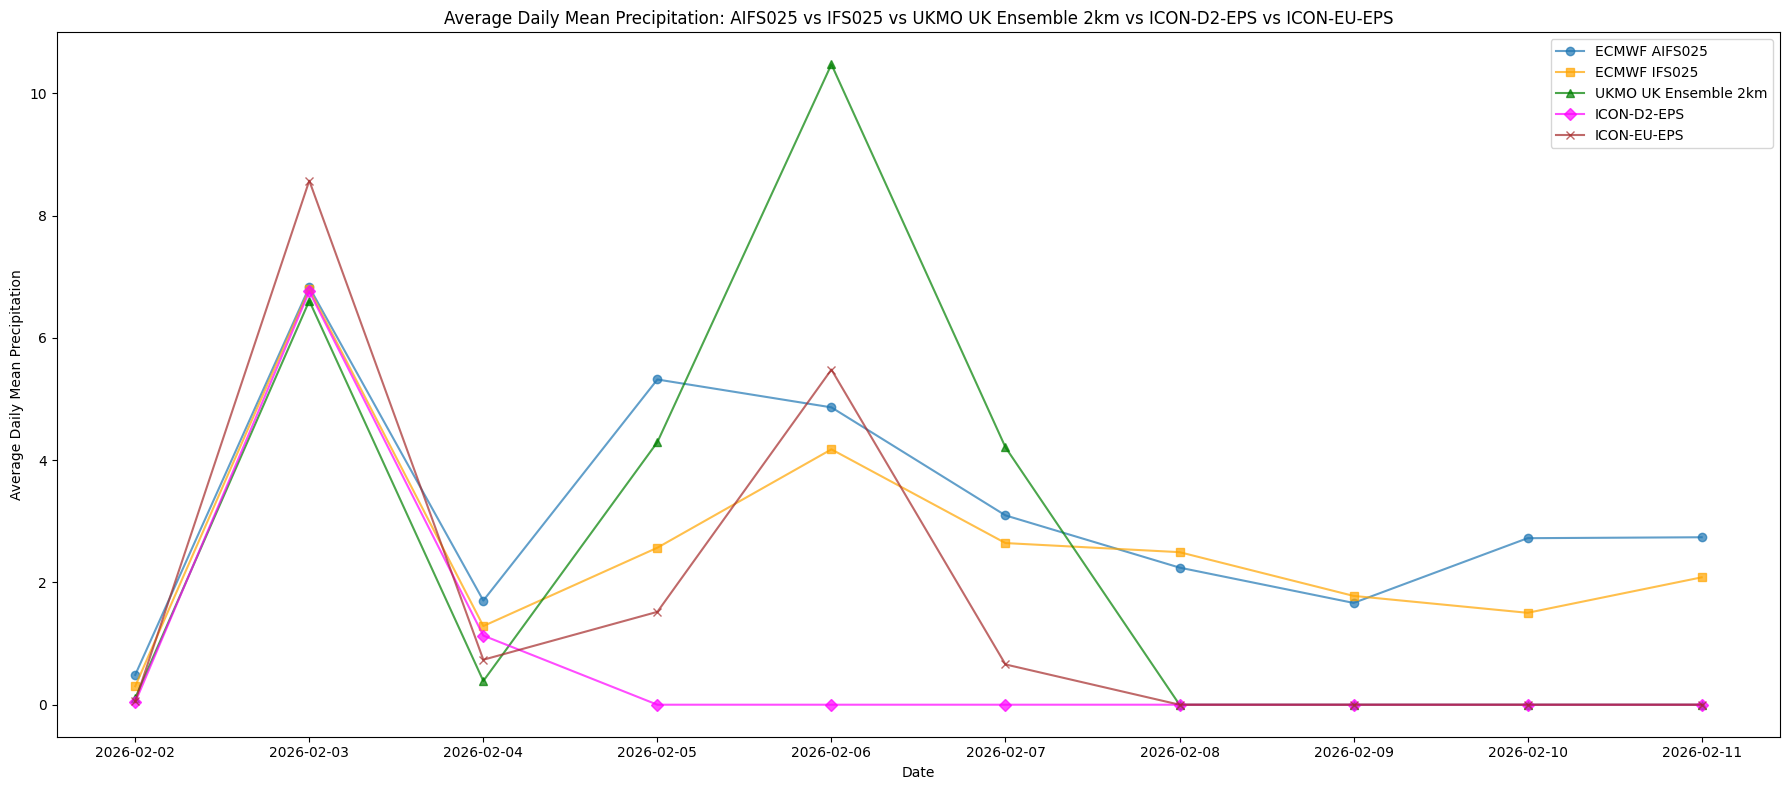

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# File paths for the five forecast rain datasets
aifs_path   = "/Users/robertds413/Documents/Flag_Predictor/data/forecast_rain_godstow_ecmwf_aifs025.csv"
ifs_path    = "/Users/robertds413/Documents/Flag_Predictor/data/forecast_rain_godstow_ecmwf_ifs025.csv"
ukmo_path   = "/Users/robertds413/Documents/Flag_Predictor/data/forecast_rain_godstow_ukmo_uk_ensemble_2km.csv"
icon_d2_path = "/Users/robertds413/Documents/Flag_Predictor/data/forecast_rain_godstow_icon_d2_eps.csv"
icon_eu_path = "/Users/robertds413/Documents/Flag_Predictor/data/forecast_rain_godstow_icon_eu_eps.csv"

# Function to load, process, and return the daily mean across *all* numeric forecast columns
def get_total_daily_mean(csv_path):
    df = pd.read_csv(csv_path)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.set_index("timestamp")
    numeric_cols = df.select_dtypes(include=np.number).columns

    # For each row, mean of all numeric forecast columns; then daily mean
    row_mean = df[numeric_cols].mean(axis=1)
    daily_mean = row_mean.resample('1D').sum()
    daily_mean_df = daily_mean.reset_index()
    daily_mean_df.columns = ["timestamp", "daily_mean"]
    return daily_mean_df

aifs_daily     = get_total_daily_mean(aifs_path)
ifs_daily      = get_total_daily_mean(ifs_path)
ukmo_daily     = get_total_daily_mean(ukmo_path)
icon_d2_daily  = get_total_daily_mean(icon_d2_path)
icon_eu_daily  = get_total_daily_mean(icon_eu_path)

# Plot average daily mean precipitation for all five datasets on the same figure
plt.figure(figsize=(18, 8))
plt.plot(aifs_daily["timestamp"], aifs_daily["daily_mean"], marker='o', label="ECMWF AIFS025", alpha=0.7)
plt.plot(ifs_daily["timestamp"], ifs_daily["daily_mean"], marker='s', label="ECMWF IFS025", alpha=0.7, color="orange")
plt.plot(ukmo_daily["timestamp"], ukmo_daily["daily_mean"], marker='^', label="UKMO UK Ensemble 2km", alpha=0.7, color="green")
plt.plot(icon_d2_daily["timestamp"], icon_d2_daily["daily_mean"], marker='D', label="ICON-D2-EPS", alpha=0.7, color="magenta")
plt.plot(icon_eu_daily["timestamp"], icon_eu_daily["daily_mean"], marker='x', label="ICON-EU-EPS", alpha=0.7, color="brown")

plt.xlabel("Date")
plt.ylabel("Average Daily Mean Precipitation")
plt.title("Average Daily Mean Precipitation: AIFS025 vs IFS025 vs UKMO UK Ensemble 2km vs ICON-D2-EPS vs ICON-EU-EPS")
plt.legend()
plt.tight_layout()
plt.show()
